# Facial Expression Recognition

In this project, we will be working with the FER2013 dataset to build a Convolutional Neural Network (CNN) for facial expression recognition. The FER2013 dataset is a widely-used benchmark dataset that contains facial images annotated with seven different emotion labels: angry, disgust, fear, happy, sad, surprise, and neutral.

The main objective of this project is to develop a CNN model that can accurately classify facial expressions based on the provided images. By training the model on a subset of the FER2013 dataset, we aim to create a model that can generalize well to new, unseen facial expressions.

In [ ]:
!pip install torchmetrics -U mlxtend

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.auto import tqdm
import pandas as pd
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.batchnorm import BatchNorm2d
from PIL import Image
import random

The data consists of 48x48 pixel grayscale images of faces. The data are stored as a string of pixel values in a csv.

In [ ]:
data = pd.read_csv('fer2013.csv')

train_data = data[data['Usage'].isin(["Training", "PublicTest"])]
test_data = data[data['Usage'] == "PrivateTest"].reset_index(drop=True)
train_data.shape, test_data.shape

((32298, 3), (3589, 3))

In [ ]:
train_images = train_data.iloc[:, 1]
train_labels = train_data.iloc[:, 0]
test_images = test_data.iloc[:, 1]
test_labels = test_data.iloc[:, 0]

In [ ]:
test_images

0       170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...
1       7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...
2       232 240 241 239 237 235 246 117 24 24 22 13 12...
3       200 197 149 139 156 89 111 58 62 95 113 117 11...
4       40 28 33 56 45 33 31 78 152 194 200 186 196 20...
                              ...                        
3584    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
3585    178 174 172 173 181 188 191 194 196 199 200 20...
3586    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
3587    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
3588    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 3589, dtype: object

In [ ]:
classes = {
0: "Angry",
1: "Disgust",
2: "Fear",
3: "Happy",
4: "Sad",
5: "Surprise",
6: "Neutral"
}

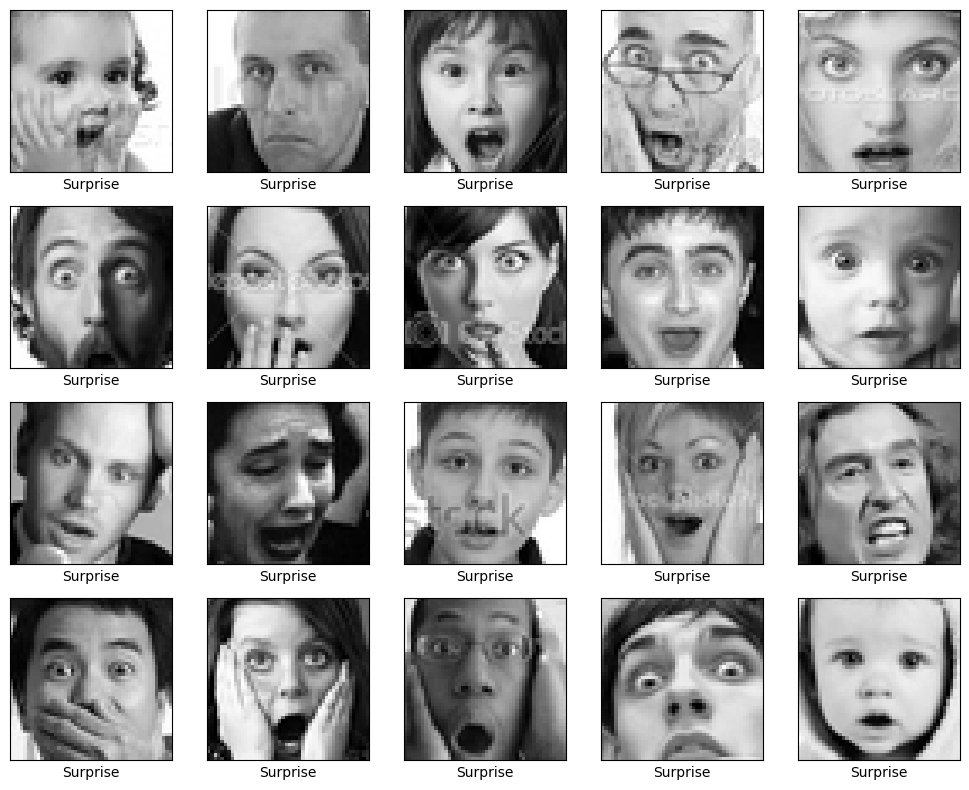

In [ ]:
def plot_random_images_with_emotion(dataset_path, emotion, num_images):
    # Load the FER2013 dataset
    fer2013 = pd.read_csv(dataset_path)
    

    # Map emotion labels to their corresponding names
    emotion_mapping = {
        0: "Angry",
        1: "Disgust",
        2: "Fear",
        3: "Happy",
        4: "Sad",
        5: "Surprise",
        6: "Neutral"
    }

    # Filter the dataset by the specified emotion
    filtered_data = fer2013[fer2013['emotion'] == emotion]

    # Check if there are enough images with the specified emotion
    if len(filtered_data) < num_images:
        print(f"Not enough images with the emotion {emotion_mapping[emotion]} in the dataset.")
        return

    # Select num_images random indices from the filtered dataset
    random_indices = random.sample(list(filtered_data.index), num_images)

    # Create subplots for the images
    fig, axes = plt.subplots(4, 5, figsize=(10, 8))
    axes = axes.ravel()

    for i, idx in enumerate(random_indices):
        pixels = filtered_data['pixels'][idx].split()
        image = np.array(pixels, 'float32').reshape(48, 48)

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xlabel(emotion_mapping[filtered_data['emotion'][idx]])

    plt.tight_layout()
    plt.show()

# Example usage: Plot 12 random images with Happy emotion
plot_random_images_with_emotion('fer2013.csv', 5, num_images=20)

To achieve better generalization, we will preprocess the FER2013 dataset, which includes transforming the images to grayscale, applying data augmentation techniques such as random cropping, horizontal flipping, and rotation, and normalizing the pixel values. These preprocessing steps are crucial for enhancing the model's ability to extract meaningful features from the images and improve its overall performance.

In [ ]:
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), inplace=True)
])

test_data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
])

In [ ]:
class FERDataset(Dataset):
    def __init__(self, images, labels, transforms):
        self.X = pd.Series(images)
        self.y = labels
        self.classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = [int(m) for m in self.X[i].split(' ')]
        data = np.asarray(data).astype(np.uint8).reshape(48,48,1)
        data = self.transforms(data)
        label = self.y[i]
        return (data, label)
    
# assigning the transformed data
train_data = FERDataset(train_images, train_labels, data_transform)
test_data = FERDataset(test_images, test_labels, test_data_transform)

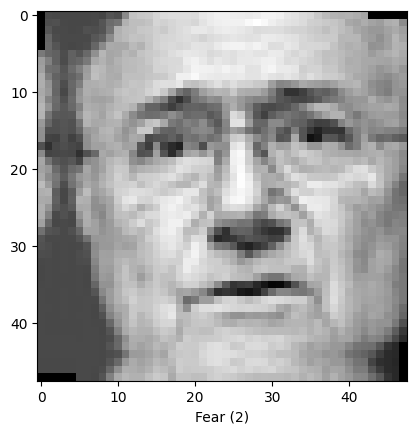

In [ ]:
# Testing data transformations
def showimg(data):
    img, lbl = data
    plt.figure()
    plt.imshow(torch.squeeze(img), cmap='gray')
    plt.xlabel(f'{classes[lbl]} ({lbl})')
    plt.plot()
    
showimg(train_data[5])

In [ ]:
batch_num = 32

train_dl = DataLoader(train_data, batch_num, shuffle=True)
test_dl = DataLoader(test_data, batch_num, shuffle=False)

In [ ]:
class CNN(nn.Module):
  def __init__(self, K):
    super().__init__()

    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(32),

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(32),

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2)
    )

    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2)
  )
    
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2)
  )

    self.dense_layers = nn.Sequential(
        nn.Flatten(),
        nn.BatchNorm1d(4608),
        nn.Dropout(0.1),
        nn.Linear(4608, 4608), # set in features to zero and use print statement. in features will be inner dim
        nn.LeakyReLU(),
        nn.BatchNorm1d(4608),
        nn.Dropout(0.1),
        nn.Linear(4608, K)
    )

  def forward(self, x):
    x = self.conv_layer1(x)
    #print(x.shape)
    x = self.conv_layer2(x)
    #print(x.shape)
    x = self.conv_layer3(x)
    #print(x.shape)
    x = self.dense_layers(x)
    #print(x.shape)
    return x

In [ ]:
K = len(classes)

In [ ]:
dummy_x = torch.rand(size=(32,1,48,48))
dummy_x.shape

torch.Size([32, 1, 48, 48])

In [ ]:
model = CNN(K=K)

In [ ]:
model(dummy_x).shape

torch.Size([32, 7])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_siz

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  # Empty tensor to track training and test losses
  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)

  # Loop over epochs
  for i in tqdm(range(epochs)):
    model.train()
    train_loss = []

    # Loop over batches, nested in epochs
    for X, y in train_loader:
      X, y = X.to(device), y.to(device)

      y_logits = model(X)

      loss = criterion(y_logits, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    train_loss = np.mean(train_loss) # Estimating epoch loss by avg batch loss

    model.eval()
    test_loss = []
    with torch.inference_mode():
      for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        loss = criterion(y_logits, y)
        test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    train_losses[i] = train_loss
    test_losses[i] = test_loss

    print(f"Epoch: {i} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_dl, test_dl, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.0560 | Test loss: 1.8207
Epoch: 1 | Train loss: 1.6193 | Test loss: 1.3044
Epoch: 2 | Train loss: 1.3835 | Test loss: 1.2472
Epoch: 3 | Train loss: 1.3143 | Test loss: 1.2291
Epoch: 4 | Train loss: 1.2676 | Test loss: 1.2282
Epoch: 5 | Train loss: 1.2434 | Test loss: 2.0879
Epoch: 6 | Train loss: 1.1982 | Test loss: 1.0940
Epoch: 7 | Train loss: 1.1352 | Test loss: 1.1462
Epoch: 8 | Train loss: 1.1142 | Test loss: 1.7135
Epoch: 9 | Train loss: 1.1012 | Test loss: 1.1264
Epoch: 10 | Train loss: 1.0621 | Test loss: 1.0776
Epoch: 11 | Train loss: 1.0389 | Test loss: 1.0793
Epoch: 12 | Train loss: 1.0169 | Test loss: 0.9780
Epoch: 13 | Train loss: 0.9887 | Test loss: 0.9823
Epoch: 14 | Train loss: 0.9812 | Test loss: 0.9978


The models test loss seems to fluctate but eventually steadily deceases.

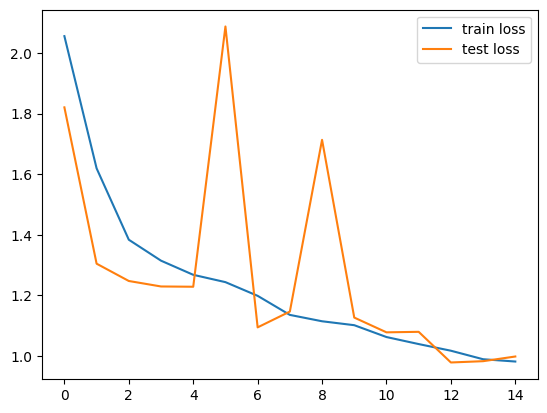

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show();

In [ ]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dl, desc="Making preds..."):
    X, y = X.to(device), y.to(device)

    y_logit = model(X)

    y_pred = torch.argmax(y_logit, dim=1)
    y_preds.append(y_pred.cpu())

# print(y_preds)

y_preds = torch.cat(y_preds)

Making preds...:   0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import torchmetrics

From the confusion matrix, we can see the model is only somewhat able to distinguish between classes.The most difficult class, Disgust, is he hardest to distinguish. This was also the less represented class in the dataset.

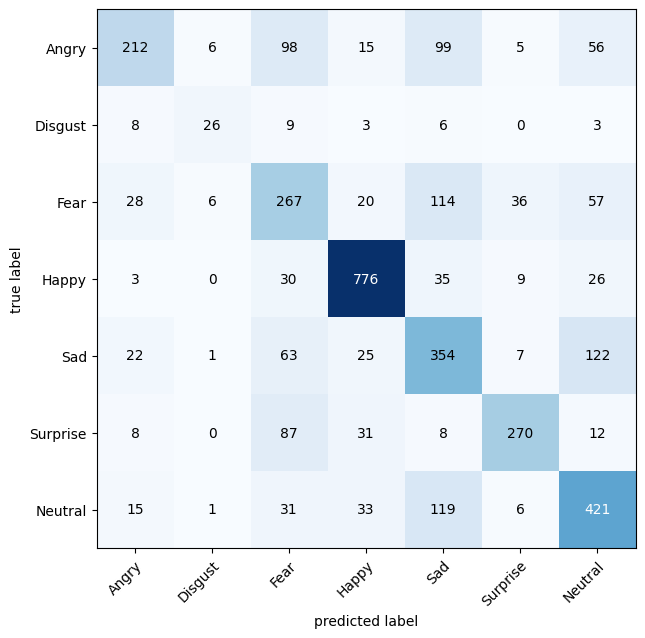

In [ ]:
cm = torchmetrics.ConfusionMatrix(num_classes=K, task="multiclass")
cm_tensor = cm(preds=y_preds, target=torch.tensor(test_labels))

fig, ax = plot_confusion_matrix(conf_mat=cm_tensor.numpy(), class_names=classes.values(), figsize=(10,7))

My model achieves an accuracy of 60%, which is actually good when compared to the [Kaggle leaderboard](https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard?) for this challenge.

In [ ]:
evaluator = torchmetrics.classification.MulticlassAccuracy(num_classes=K)
evaluator(y_preds, torch.tensor(test_labels))

tensor(0.6015)

In [ ]:
def plot_top_losses(model, test_loader, k):
    model.eval()
    device = next(model.parameters()).device

    # Make predictions on the test data
    predictions = []
    probabilities = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            probabilities_batch = torch.softmax(outputs, dim=1).max(dim=1)[0]
            predictions.extend(predicted.tolist())
            probabilities.extend(probabilities_batch.tolist())
            true_labels.extend(labels.tolist())

    # Find the indices of the incorrect predictions
    incorrect_indices = [i for i in range(len(predictions)) if predictions[i] != true_labels[i]]

    # Sort the incorrect predictions based on highest probability
    incorrect_indices.sort(key=lambda i: probabilities[i], reverse=True)
    top_k_indices = incorrect_indices[:k]

    # Calculate the number of rows and columns for the grid
    rows = int(k ** 0.5)
    cols = (k + rows - 1) // rows

    # Plot the top-k incorrect images in a square grid
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, idx in enumerate(top_k_indices):
        image, _ = test_loader.dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        row = i // cols
        col = i % cols
        ax = axes[row, col] if k > 1 else axes
        ax.imshow(image, cmap="gray")
        ax.set_title(f"True: {test_loader.dataset.classes[true_labels[idx]]}\nPredicted: {test_loader.dataset.classes[predictions[idx]]}\nProbability: {probabilities[idx]:.4f}")
        ax.axis('off')

    # Remove empty subplots if there are fewer images than subplots
    for i in range(k, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if k > 1 else axes
        ax.axis('off')

    plt.tight_layout()
    plt.show()

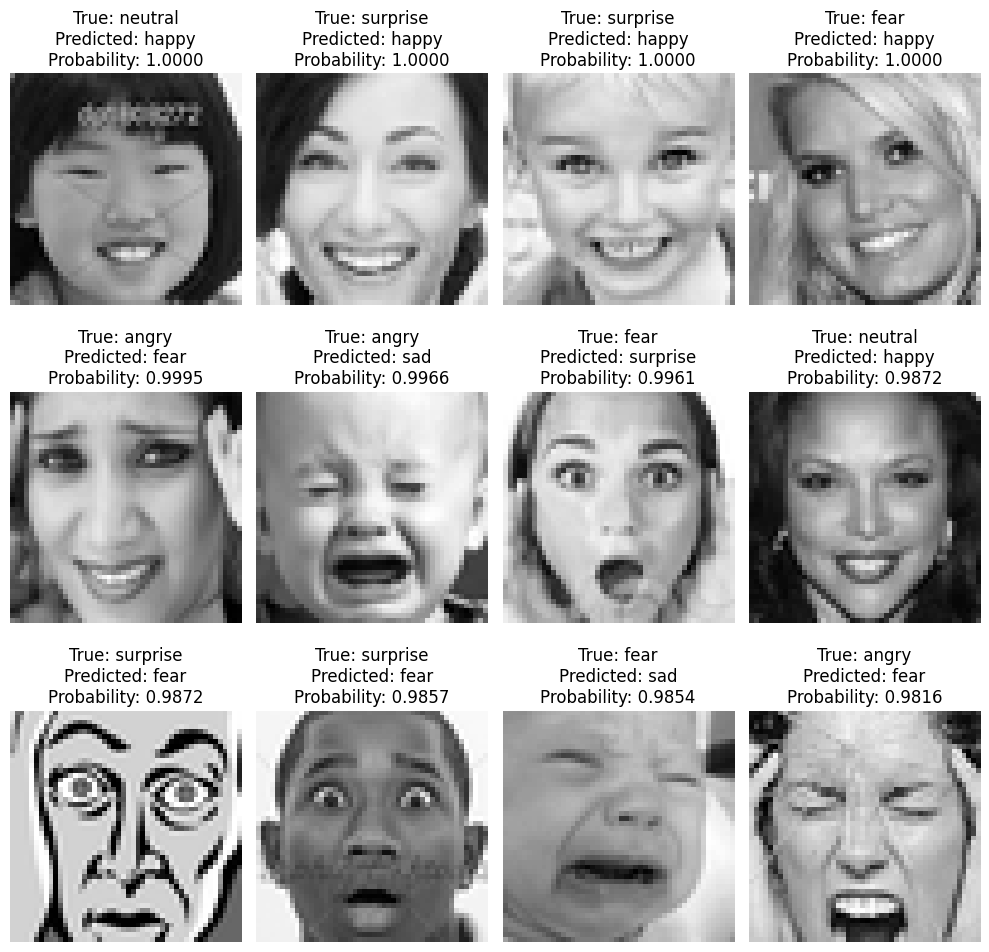

In [ ]:
plot_top_losses(model, test_dl, 12)

From plotting the top losses, we see the model has a hard time with fear, surprise, and angry. By themselves, these expressions might even be difficult for a human to classify. Also, it is known that some of the labels in the FER2013 dataset are incorrect, and some of the images themselves are noisy or not suitable for modelling. We see instances of cartoon/anime faces, watermarked images, text or pitch black images, etc.

Overall, there are inherent limitations with this dataset. This has prompted Microsoft to produce the [FER+ dataset](https://github.com/microsoft/FERPlus), which seeks to correct these issues. Nonetheless, it is interesting to explore some common pitfalls when building these models, such as needing to ensure high-quality data, and being able to process images stored in unconventional ways.